Importing libraries

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import math
import numpy as np
import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 17
torch.manual_seed(seed)

Image transformations, datasets and dataloaders

In [ ]:
data_dir = "/content/drive/MyDrive/CIFAR-10/"
batch_size = 128 #"These models are trained with a minibatch size of 128"

#"Network inputs 32x32 images with per-pixel mean subtracted."
def normalize_transform():
  return transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], #mean values obtained here: https://github.com/kuangliu/pytorch-cifar/issues/19
                              std = [1, 1, 1]) #notably there is no division by a non-one number

trainval_transforms = transforms.Compose([
    transforms.Pad(padding=4), #"We follow the simple data augmentation in [24] for training: 4 pixels are padded on each side,
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop((32, 32)), #"and a 32×32 crop is randomly sampled from the padded image or its horizontal flip."
    transforms.ToTensor(), #convert to tensor
    normalize_transform() #normalize
])

trainval_dataset = datasets.CIFAR10(data_dir, train=True, transform = trainval_transforms, download=True)

val_size = 5000 #train/val split; "45k/5k train/val split"
train_size = len(trainval_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# "For testing, we only evaluate the single view of the original 32×32 image."
test_transforms = transforms.Compose([
    transforms.ToTensor(), #convert to tensor
    normalize_transform() #normalize          
])

test_dataset = datasets.CIFAR10(data_dir, train=False, transform = test_transforms)

#dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("training images: ",len(train_dataset), "; validation images:", len(val_dataset), "; test images: ", len(test_dataset))

Files already downloaded and verified
training images:  45000 ; validation images: 5000 ; test images:  10000


Viewing normalized images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images AFTER NORMALIZATION
--------------------------
images.shape: torch.Size([128, 3, 32, 32])


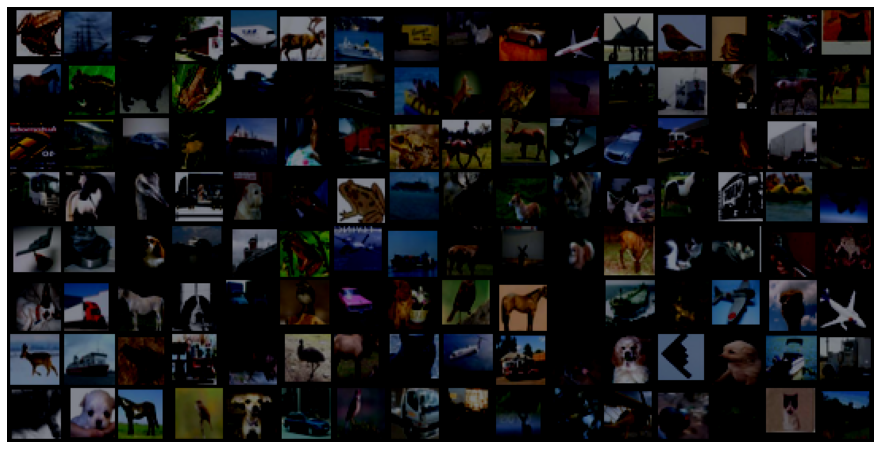

In [ ]:
#https://medium.com/@sergioalves94/deep-learning-in-pytorch-with-cifar-10-dataset-858b504a6b54
print("Images AFTER NORMALIZATION")
print("--------------------------")
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Defining neural network

In [ ]:
def initialize_weights(self):
  for m in self.modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
      nn.init.kaiming_normal_(m.weight) #"adopt the weight initialization in [Delving deep into rectifiers...]"

class block(nn.Module):
  def __init__(self, in_channels, out_channels, subsampling=False):
    super(block, self).__init__()
    self.convy_1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, 
                             kernel_size=3, stride= 2 if subsampling else 1, padding=1,
                             bias=False) #"The subsampling is performed by convolutions with a stride of 2." #16 = floor[({32+2p-3}/2)+1] if p=1
    self.bn1 = nn.BatchNorm2d(out_channels) #"We adopt batch normalization (BN) right after each convolution and before [ReLU] activation"
    self.relu1 = nn.ReLU()
    self.convy_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.subsampling = subsampling

  def forward(self, x):
    identity = x.clone()

    if self.subsampling == True:
      #"In this case we use identity shortcuts in all cases (i.e. option A)"
      #"(A) The shortcut still performs identity mapping, with extra zero entries padded for increasing dimensions. This option introduces no extra parameter"
      #"when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2."
      #I was very stuck on how to zero pad so I looked at Yerlan Idelbayev's https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py
      identity = F.pad(input=identity[:,:,::2,::2], pad=(0, 0, 0, 0, self.out_channels//4, self.out_channels//4), mode='constant', value=0)

    x = self.convy_1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.convy_2(x)
    x = self.bn2(x)
    
    x += identity
    x = self.relu2(x)
    return x

class ResNet(nn.Module):
  def __init__(self, block, image_channels, n, num_classes):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = image_channels, out_channels = 16, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(16)
    self.relu = nn.ReLU() #no maxpool

    #ResNet layers
    self.n = n #n such that "[t]here are totally 6n+2 stacked weighted layers."
    self.block1 = block(16, 16)
    self.block2 = self.make_layers(in_channels=16, out_channels=16)
    self.block3 = block(16, 32, subsampling=True)
    self.block4 = self.make_layers(in_channels=32, out_channels=32)
    self.block5 = block(32, 64, subsampling=True)
    self.block6 = self.make_layers(in_channels=64, out_channels=64)

    #"The network ends with a global average pooling, a 10-way fully-connected layer, and softmax."
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(64, num_classes) #no softmax as cross-entropy loss does that

    self.apply(initialize_weights)
  
  def make_layers(self, in_channels, out_channels):
    layers = []
    for i in range(self.n-1):
      layers.append(block(in_channels, out_channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1) #https://pytorch.org/docs/stable/generated/torch.reshape.html
    x = self.fc(x)

    return x

Training parameters

In [ ]:
#import torch.optim as optim
#import torch.nn as nn
#import math

weight_decay = 0.0001 #We use a weight decay of 0.0001
momentum = 0.9 #momentum of 0.9
learning_rate = 0.1 #"We start with a learning rate of 0.1, divide it by 10 at 32k and 48 iterations, and terminate training at 64k iterations, which is determined on a 45k/5k/val split."
num_classes = 10

#n_total_steps = len(train_loader)
training_iterations = 64000 #"terminate training at 64k iterations"
training_epochs = math.ceil(training_iterations/math.ceil(len(train_dataset)/batch_size))
print(f"Training will require {training_epochs} epochs")

num_blocks = [3, 5, 7, 9] #the 'n' parameters corresponding to the models you'd like to create
model_depths = [6*k + 2 for k in num_blocks] #ResNet20 corresponds to n=3, ResNet32 corresponds to n=5, ResNet44 corresponds to n=7, ResNet56 corresponds to n=9
resnet_models = [ResNet(block, image_channels=3, n=k, num_classes = num_classes) for k in num_blocks]
for i in resnet_models:
  i.to(device)

def count_parameters(model): #obtained here: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/8
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
for i in range(len(resnet_models)):
  print(f"Model ResNet{model_depths[i]} has ", count_parameters(resnet_models[i]), " trainable parameters")

criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(i.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay) for i in resnet_models]
#"We start with a learning rate of 0.1, divide it by 10 at 32k and 48k iterations"
schedulers = [optim.lr_scheduler.MultiStepLR(j, milestones=[31999, 47999], gamma=0.1) for j in optimizers]

Training will require 182 epochs
Model ResNet20 has  269722  trainable parameters
Model ResNet32 has  464154  trainable parameters
Model ResNet44 has  658586  trainable parameters
Model ResNet56 has  853018  trainable parameters


Training loop (not necessary to run if you've already trained)

In [ ]:
if input("Are you sure you want to begin training and saving models? Select (Y/N): ") != "Y":
    exit()
else:
  for i in range(len(resnet_models)):
    for epoch in range(training_epochs):
      running_loss = 0.0
      for j, data in enumerate(train_loader, start=0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #inputs = inputs.reshape(-1, 224*224).to(device)
        #labels = labels.to(device)

        outputs = resnet_models[i](inputs) #forwards
        loss = criterion(outputs, labels) #calculate loss
        loss.backward() #backwards
        optimizers[i].step() #optimize
        optimizers[i].zero_grad() #zero the parameter gradients

        #print epoch information
        running_loss += loss.item()
        
        #scheduler.step() called each ITERATION not epoch
        schedulers[i].step()
      print(f'Epoch {epoch + 1}, loss: {running_loss}')
    #https://stackoverflow.com/questions/32490629/getting-todays-date-in-yyyy-mm-dd-in-python
    today = datetime.datetime.today().strftime('%Y-%m-%d')
    path = f'/content/drive/MyDrive/{today}_cifar_resnet{model_depths[i]}.pth'
    torch.save(resnet_models[i].state_dict(), path)
    print('Model saved.')

  print('All models trained.')

Epoch 1, loss: 680.7320348024368
Epoch 2, loss: 481.97289645671844
Epoch 3, loss: 370.2890188097954
Epoch 4, loss: 303.6378341913223
Epoch 5, loss: 266.72408747673035
Epoch 6, loss: 242.6754465699196
Epoch 7, loss: 225.0396230518818
Epoch 8, loss: 212.8778119981289
Epoch 9, loss: 200.64513126015663
Epoch 10, loss: 190.89948070049286
Epoch 11, loss: 182.2003977894783
Epoch 12, loss: 174.24201211333275
Epoch 13, loss: 169.25322011113167
Epoch 14, loss: 162.29741421341896
Epoch 15, loss: 158.2343677431345
Epoch 16, loss: 153.22377836704254
Epoch 17, loss: 151.49371644854546
Epoch 18, loss: 146.72440645098686
Epoch 19, loss: 140.4986029267311
Epoch 20, loss: 139.68475271761417
Epoch 21, loss: 137.3333339393139
Epoch 22, loss: 134.66061808168888
Epoch 23, loss: 129.63524340093136
Epoch 24, loss: 126.19982782006264
Epoch 25, loss: 128.60471686720848
Epoch 26, loss: 124.08889169991016
Epoch 27, loss: 122.60332319140434
Epoch 28, loss: 119.69951671361923
Epoch 29, loss: 118.41559307277203
Epoc

Validation

In [ ]:
#Validating ResNets

#re-create model architectures
#MANUAL INSERTION OF num_blocks FOR MODELS REQUIRED
num_blocks = [3, 5, 7, 9] #the 'n' parameters corresponding to the models you'd like to create
model_depths = [6*k + 2 for k in num_blocks] #ResNet20 corresponds to n=3, ResNet32 corresponds to n=5, ResNet44 corresponds to n=7, ResNet56 corresponds to n=9
resnet_models = [ResNet(block, image_channels=3, n=k, num_classes = num_classes) for k in num_blocks]
for i in resnet_models:
  i.to(device)

#insert model weights and evaluate
#https://pytorch.org/docs/stable/notes/serialization.html
#MANUAL INSERTION OF PATHS REQUIRED
PATHS = ['/content/drive/MyDrive/2022-04-15_cifar_resnet20.pth',
         '/content/drive/MyDrive/2022-04-15_cifar_resnet32.pth',
         '/content/drive/MyDrive/2022-04-15_cifar_resnet44.pth',
         '/content/drive/MyDrive/2022-04-15_cifar_resnet56.pth']
for i in range(len(resnet_models)):
  if device == 'cuda':
    resnet_models[i].load_state_dict(torch.load(PATHS[i], map_location=torch.device('cuda')))
  else:
    resnet_models[i].load_state_dict(torch.load(PATHS[i], map_location=torch.device('cpu')))
  
  resnet_models[i].eval()

  accuracy_denom = len(val_dataset)
  top1_accuracy_numer = 0
  with torch.no_grad():
    for j, data in enumerate(val_loader, start=0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = resnet_models[i](inputs)
      _, predicted = torch.max(outputs,1)
      #just like the labels, predicted is a tensor of (usually) batch_size length, with nums corresponding to the most likely classes
      #top-1 accuracy
      for k in range(len(predicted)):
        top1_accuracy_numer += 1 if predicted[k] == labels[k] else 0
  print(f"Top-1 accuracy of ResNet-{model_depths[i]} is {top1_accuracy_numer*100/accuracy_denom}%")


Top-1 accuracy of ResNet-20 is 91.1%
Top-1 accuracy of ResNet-32 is 91.7%
Top-1 accuracy of ResNet-44 is 91.88%
Top-1 accuracy of ResNet-56 is 92.0%


Testing

In [ ]:
#Testing ResNets

#re-create model architectures
#MANUAL INSERTION OF num_blocks FOR MODELS REQUIRED
num_blocks = [3, 5, 7, 9] #the 'n' parameters corresponding to the models you'd like to create
model_depths = [6*k + 2 for k in num_blocks] #ResNet20 corresponds to n=3, ResNet32 corresponds to n=5, ResNet44 corresponds to n=7, ResNet56 corresponds to n=9
resnet_models = [ResNet(block, image_channels=3, n=k, num_classes = num_classes) for k in num_blocks]
for i in resnet_models:
  i.to(device)

#insert model weights and evaluate
#https://pytorch.org/docs/stable/notes/serialization.html
#MANUAL INSERTION OF PATHS REQUIRED
PATHS = ['/content/drive/MyDrive/2022-04-15_cifar_resnet20.pth',
         '/content/drive/MyDrive/2022-04-15_cifar_resnet32.pth',
         '/content/drive/MyDrive/2022-04-15_cifar_resnet44.pth',
         '/content/drive/MyDrive/2022-04-15_cifar_resnet56.pth']
for i in range(len(resnet_models)):
  if device == 'cuda':
    resnet_models[i].load_state_dict(torch.load(PATHS[i], map_location=torch.device('cuda')))
  else:
    resnet_models[i].load_state_dict(torch.load(PATHS[i], map_location=torch.device('cpu')))
  
  resnet_models[i].eval()

  accuracy_denom = len(test_dataset)
  top1_accuracy_numer = 0
  with torch.no_grad():
    for j, data in enumerate(test_loader, start=0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = resnet_models[i](inputs)
      _, predicted = torch.max(outputs,1)
      #just like the labels, predicted is a tensor of (usually) batch_size length, with nums corresponding to the most likely classes
      #top-1 accuracy
      for k in range(len(predicted)):
        top1_accuracy_numer += 1 if predicted[k] == labels[k] else 0
  print(f"Top-1 accuracy of ResNet-{model_depths[i]} is {top1_accuracy_numer*100/accuracy_denom}%")


Top-1 accuracy of ResNet-20 is 90.63%
Top-1 accuracy of ResNet-32 is 92.36%
Top-1 accuracy of ResNet-44 is 92.07%
Top-1 accuracy of ResNet-56 is 92.36%
